<font size="6">Main script to call functions from other scripts</font> 

#  Import libraries

In [1]:
# data manipulations
import numpy as np
import pandas as pd

# pypark
from pyspark.ml import PipelineModel  # to load the pipeline
from threading import Thread
from pyspark.streaming import StreamingContext

# evaluation statistics
from sklearn.metrics import confusion_matrix

# performance evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

# visualize
import matplotlib.pyplot as plt

# own functions
from functions.performance.metrics import plot_confusion_matrix 

In [2]:
# when you change somehting in your own library (e.g. plot_confusion_matrix) it's automatically updated, you don't need to reimport
%load_ext autoreload
%autoreload 2

# Global variables

In [3]:
# avaialble plotting styles
print(plt.style.available)
plt.style.use('bmh')

# global variables in CAPITAL letters
PATH_LOAD_MODEL = "../output/models/logistic_regression"
SAVE_PREDICTIONS = True # save predictions
PATH_SAVE_PREDICTIONS = "../../output/predictions/logistic_regression.parquet" # where to save the predictions
VERBOSE = True # print intermediate output

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test', '_classic_test_patch']


# Get streaming instances

In [14]:
class StreamingThread(Thread):
    def __init__(self, ssc):
        Thread.__init__(self)
        self.ssc = ssc
    # Start stream
    def run(self):
        ssc.start()
        ssc.awaitTermination()
    # Stop stream
    def stop(self):
        print('----- Stopping... this may take a few seconds -----')
        self.ssc.stop(stopSparkContext=False, stopGraceFully=True)

#  Load Pipeline 1

This pipeline cleans the data and get the data in the right format

**TODO**

```python
instead of calling  %run "pipeline1.ipynb"  
make a proper libary so we can call from functions.data_cleaning import pipeline1
```
for an example see 

```python 
from functions.performance.metrics import plot_confusion_matrix  
```
this is also a self defined library

**Why?** now we have to uncomment code,  because we want to reuse the code in other notebooks,
leaving it like this seems bit clumpsy

In [15]:
# Initialize other notebooks
%run "pipeline1.ipynb"

# Load Pipeline 2

feature engineering steps and final prediction model

In [16]:
pipeline2 = PipelineModel.load(PATH_LOAD_MODEL)

#  Full pipeline

In [17]:
def final_pipeline(time, rdd, save_predictions=SAVE_PREDICTIONS, path=PATH_SAVE_PREDICTIONS, verbose=VERBOSE):
    """""" """
    This function will serve as the construction pipeline.
    Here all preprocessing functions need to be called and 
    need to be able to handle one wiki edit.
    """ """"""
    if rdd.isEmpty():
        return
    if verbose:
        print("========= %s =========" % str(time))

    # -------------------------------------------------------------------------
    # 1) Pipeline 1: Mostly data cleaning and getting data in the right shape
    # -------------------------------------------------------------------------
    df = spark.read.json(rdd)
    clean_df = get_clean_df(df)
    df_with_difference = get_difference_column(clean_df)
    final_df = split_difference_into_removed_added(df_with_difference)
    
    print(f"Result after pipeline 1:")
    if verbose:
        final_df.show(2)
        
    # ------------------------------------------------------------------------
    # 2) Pipeline 2: Feature engineering, and Predicting
    # ------------------------------------------------------------------------
    predictions = pipeline2.transform(final_df)
    print("Result after pipeline 2 (predictions):")
    if verbose:
        predictions.select(['target', 'label', 'prediction','probability']).show(2)
    # save predictions
    if save_predictions: 
        print(f"saving predictions of batch in: {path}")
        predictions.write.mode("append").save(path)
        

# Begin online stream and make prediction per wiki edit

In [18]:
ssc = StreamingContext(sc, 10) # Get minibatches every 10 seconds

In [19]:
lines = ssc.socketTextStream("seppe.net", 7778)
lines.foreachRDD(final_pipeline)

In [20]:
ssc_t = StreamingThread(ssc)
ssc_t.start()

========= 2020-05-30 11:50:30 =========
Result after pipeline 1:
+------+----------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+
| label|   comment|          title_page|      name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+------+----------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+
|unsafe|fixed typo|    oscar de la hoya|     8478247235|short description...|short description...|[name, scar, de, ...|[name, oscar, de,...|
|  safe|     empty|university of ben...|yansen bengkulu|infobox universit...|infobox universit...|[, previous, rect...|             [empty]|
+------+----------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+

Result after pipeline 2 (predictions):
+------+------+----------+--------------------+
|

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.91443678350692...|
|   0.0| safe|       0.0|[0.95527193571111...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 11:52:10 =========
Result after pipeline 1:
+-----+------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|label|           comment|          title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| safe|betfixed cs1 error|american basketba...|john b123|the american bask...|

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.90576621252004...|
|   0.0| safe|       0.0|[0.68839618030048...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 12:01:30 =========
Result after pipeline 1:
+-----+---------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|label|        comment|          title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+---------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| safe|          empty|         l'intrepido|  lugnuts|forthe comics mag...|forthe comics mag...|[use, dmy, date

========= 2020-05-30 12:15:20 =========
Result after pipeline 1:
+------+----------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
| label|   comment|          title_page|   name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+------+----------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
|  safe|pantomimes|gordon craig theatre|  andypurves|use british engli...|use british engli...|[classwikitable, , ]|[classwikitable, ...|
|unsafe|     empty|    american network|171236121117|abouta television...|abouta television...|[drama, this, is,...|[hunter, 1984, am...|
+------+----------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows

Result after pipeline 2 (predictions):
+------+------+----------+-----------------

Result after pipeline 2 (predictions):
+------+------+----------+--------------------+
|target| label|prediction|         probability|
+------+------+----------+--------------------+
|   1.0|unsafe|       1.0|[0.16711995475778...|
|   0.0|  safe|       0.0|[0.99075235135074...|
+------+------+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 12:33:00 =========
Result after pipeline 1:
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+
| label|             comment|          title_page|           name_user|      clean_old_text|      clean_new_text|       removed_words|added_words|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+
|  safe|v202 - fixing syn...|              dasuya|       

+-----+--------------------+------------+---------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|  title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+------------+---------+--------------------+--------------------+--------------------+--------------------+
| safe|afliawk 1lib1ref ...|yakubu gowon| na'angap|infobox officehol...|infobox officehol...|[booklastkasukafi...|[ation, n, ededda...|
+-----+--------------------+------------+---------+--------------------+--------------------+--------------------+--------------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.87667906793543...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output

Result after pipeline 2 (predictions):
+------+------+----------+--------------------+
|target| label|prediction|         probability|
+------+------+----------+--------------------+
|   0.0|  safe|       0.0|[0.65893591623010...|
|   1.0|unsafe|       1.0|[0.44932044690024...|
+------+------+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 12:48:20 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------+
|label|             comment|          title_page|        name_user|      clean_old_text|      clean_new_text|       removed_words|        added_words|
+-----+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------+
| safe|toptypo fixing re...|daniel mendes foo...|werespielchequers|sh

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       1.0|[0.47365045287990...|
|   0.0| safe|       1.0|[0.28234105812973...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 12:50:20 =========
Result after pipeline 1:
+-----+--------------------+--------------------+--------------+--------------------+--------------------+-------------+-----------+
|label|             comment|          title_page|     name_user|      clean_old_text|      clean_new_text|removed_words|added_words|
+-----+--------------------+--------------------+--------------+--------------------+--------------------+-------------+-----------+
| safe|corrected typo an...|academic ranks in...|sempercontendo|refimprovedatedec...|refimprovedatedec...|      [empty]|    [empt

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.97862665963098...|
|   0.0| safe|       1.0|[0.00210921314323...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 12:52:20 =========
Result after pipeline 1:
+-----+--------------------+------------------+--------------+--------------------+--------------------+--------------------+-----------+
|label|             comment|        title_page|     name_user|      clean_old_text|      clean_new_text|       removed_words|added_words|
+-----+--------------------+------------------+--------------+--------------------+--------------------+--------------------+-----------+
| safe|               empty|           nae nae|  figureman453|short description...|short d

========= 2020-05-30 13:04:20 =========
Result after pipeline 1:
+------+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
| label|             comment|        title_page|        name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+------+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|unsafe|spell out second ...|     super session|             pjtp|aboutthe album by...|aboutthe album by...|[artist, hlistmik...|[artist, mike, bl...|
|  safe|toptypo fixing re...|jay kennedy harris|werespielchequers|use australian en...|use australian en...|             [e, , ]|             [r, , ]|
+------+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows

Resu

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.75760315642467...|
|   0.0| safe|       1.0|[0.42491358700502...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 13:20:30 =========
Result after pipeline 1:
+------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+
| label|             comment|          title_page|           name_user|      clean_old_text|      clean_new_text|removed_words|         added_words|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+
|  safe|v202 - fix wpwcwp...|1990 in the unite...|           theimacow|yearbox us

========= 2020-05-30 13:35:20 =========
Result after pipeline 1:
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+
|label|             comment|          title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|added_words|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+
| safe|disambiguating li...|      1793 in france|     rodw|year in france179...|year in france179...|[islandsan, pietr...|    [empty]|
| safe|v202 - fix wpwcwp...|2006 ibf world ch...|theimacow|infobox sports co...|infobox sports co...|             [empty]|    [empty]|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         prob

Result after pipeline 2 (predictions):
+------+------+----------+--------------------+
|target| label|prediction|         probability|
+------+------+----------+--------------------+
|   0.0|  safe|       0.0|[0.93702136408284...|
|   1.0|unsafe|       1.0|[0.40719121816936...|
+------+------+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 13:37:40 =========
Result after pipeline 1:
+-----+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|         name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 -wpwcwprojec...|avondale un

========= 2020-05-30 13:40:40 =========
Result after pipeline 1:
+-----+--------------------+--------------+-----------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|    title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------+-----------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|201213 la liga|  theimacow|infobox football ...|infobox football ...|[nameathathletic,...|[nameathathletic,...|
| safe|residents and vis...|       eriskay|archon 2488|distinguisheriska...|distinguisheriska...|             [empty]|             [empty]|
+-----+--------------------+--------------+-----------+--------------------+--------------------+--------------------+--------------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|

Result after pipeline 2 (predictions):
+------+------+----------+--------------------+
|target| label|prediction|         probability|
+------+------+----------+--------------------+
|   0.0|  safe|       0.0|[0.99747993499874...|
|   1.0|unsafe|       0.0|[0.54831764125800...|
+------+------+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 13:42:10 =========
Result after pipeline 1:
+-----+--------------------+--------------------+---------+--------------------+--------------------+-------------+-----------+
|label|             comment|          title_page|name_user|      clean_old_text|      clean_new_text|removed_words|added_words|
+-----+--------------------+--------------------+---------+--------------------+--------------------+-------------+-----------+
| safe|spelling wp typo ...|     history of nato|    cyfal|short description...|short description...|      [e, , ]|        [r]|
| safe|v20

========= 2020-05-30 13:44:20 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|201213 rit tigers...|  theimacow|ncaaicehockeyteam...|ncaaicehockeyteam...|[201213, cha, hoc...|[template201213, ...|
| safe|forty-ounceadd co...|         malt liquor|archon 2488|short description...|short description...|[+in, the, americ...|[in, the, america...|
+-----+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+

Result after pipeline 2 (predictions):
+------+-----+-----

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.93399049854878...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 13:46:20 =========
Result after pipeline 1:
+-----+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+-----------+
|label|             comment|         title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|added_words|
+-----+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+-----------+
| safe|v202 - fix wpwcwp...|201314 liga iv alba|  theimacow|short description...|short description...|[defaultsort2013-...|    [empty]|
| safe|               empty|   

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.90666872235316...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 13:48:20 =========
Result after pipeline 1:
+-----+--------------------+--------------+--------------+--------------------+--------------------+---------------+-----------+
|label|             comment|    title_page|     name_user|      clean_old_text|      clean_new_text|  removed_words|added_words|
+-----+--------------------+--------------+--------------+--------------------+--------------------+---------------+-----------+
| safe|biogerontologyfix...|   gerontology|    thefauxfoe|short description...|short description...|        [empty]|    [and, ]|
| safe|           reference|dhordo village|rajeev gaur123|'

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.98919799588788...|
|   0.0| safe|       1.0|[0.21827969175138...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 13:49:40 =========
Result after pipeline 1:
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| safe|disambiguating li...|list of military ...|     rodw|multiple issu

========= 2020-05-30 13:51:10 =========
Result after pipeline 1:
+------+------------------+------------------+-----------+--------------------+--------------------+--------------------+--------------------+
| label|           comment|        title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+------+------------------+------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|unsafe|             empty|politics of kerala|42106182112|use dmy datesdate...|use dmy datesdate...|        [cpmcpi, , ]|[filepinarayijpgt...|
|  safe|add notable people|      fremont ohio| gdrown2013|infobox settlemen...|infobox settlemen...|[greg, drown, sma...|             [empty]|
+------+------------------+------------------+-----------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows

Result after pipeline 2 (predictions):
+------+-----

========= 2020-05-30 13:52:30 =========
Result after pipeline 1:
+-----+-------+--------------------+---------+--------------------+--------------------+-------------+-----------+
|label|comment|          title_page|name_user|      clean_old_text|      clean_new_text|removed_words|added_words|
+-----+-------+--------------------+---------+--------------------+--------------------+-------------+-----------+
| safe|  empty|sumitomo mitsui b...|  hoba789|short description...|short description...|      [s, , ]| [, , an, ]|
+-----+-------+--------------------+---------+--------------------+--------------------+-------------+-----------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       1.0|[0.14216771999918...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.97738845565063...|
|   0.0| safe|       0.0|[0.98104664671829...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:07:50 =========
Result after pipeline 1:
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+
|label|             comment|          title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|added_words|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+
| safe|theme packsadded ...|       uno card game|unoaddict|short description...|short description..

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.99583598974351...|
|   0.0| safe|       0.0|[0.79824718099525...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:25:30 =========
Result after pipeline 1:
+-----+------------------+-----------+---------+--------------------+--------------------+-------------+-----------+
|label|           comment| title_page|name_user|      clean_old_text|      clean_new_text|removed_words|added_words|
+-----+------------------+-----------+---------+--------------------+--------------------+-------------+-----------+
| safe|minor style change|kevin berln|   simeon|short description...|short description...|      [empty]|    [empty]|
+-----+------------------+----------

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.68483259495645...|
|   0.0| safe|       0.0|[0.63352574238317...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:27:00 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|        name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|201920 jwaneng ga...|        theimacow|infob

========= 2020-05-30 14:28:50 =========
Result after pipeline 1:
+-----+--------------------+--------------------+---------+--------------------+--------------------+---------------+--------------------+
|label|             comment|          title_page|name_user|      clean_old_text|      clean_new_text|  removed_words|         added_words|
+-----+--------------------+--------------------+---------+--------------------+--------------------+---------------+--------------------+
| safe|  link-fix siirtspor|         alpay zalan|     isik|use dmy datesdate...|use dmy datesdate...|[sporsiirt, , ]|             [empty]|
| safe|v202 - fix wpwcwp...|2020 houston astr...|theimacow|use mdy datesdate...|use mdy datesdate...|        [empty]|[covid-19, pandemic]|
+-----+--------------------+--------------------+---------+--------------------+--------------------+---------------+--------------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.62027421067599...|
|   0.0| safe|       0.0|[0.57390963126228...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:30:10 =========
Result after pipeline 1:
+-----+--------------------+----------------+---------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|      title_page|      name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+----------------+---------------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|        kaa elan|      theimacow|'''kaa elan''' bo...|'''kaa e

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.99407078013476...|
|   0.0| safe|       1.0|[0.07950337391317...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:32:10 =========
Result after pipeline 1:
+-----+--------+--------------+---------+--------------------+--------------------+--------------------+--------------------+
|label| comment|    title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------+--------------+---------+--------------------+--------------------+--------------------+--------------------+
| safe|spelling|balinese dance|  woodlot|short description...|short description...|[tenun, a, dance,...|[tenun, a, dance,...|
| safe| padlock|    yevp

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       1.0|[0.42321970840582...|
|   0.0| safe|       0.0|[0.61183687457842...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:34:10 =========
Result after pipeline 1:
+-----+--------------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|    title_page|     name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+
| safe|hydrogenation cat...| shvo catalyst|     smokefoot|chembox watchedfi

Result after pipeline 2 (predictions):
+------+------+----------+--------------------+
|target| label|prediction|         probability|
+------+------+----------+--------------------+
|   1.0|unsafe|       0.0|[0.86770341619379...|
|   1.0|unsafe|       1.0|[0.29767700736013...|
+------+------+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:35:40 =========
Result after pipeline 1:
+------+-------+------------------+------------+--------------------+--------------------+-------------------+---------------+
| label|comment|        title_page|   name_user|      clean_old_text|      clean_new_text|      removed_words|    added_words|
+------+-------+------------------+------------+--------------------+--------------------+-------------------+---------------+
|unsafe|   typo|waffle house index|184103218104|use mdy datesdate...|use mdy datesdate...|[br, n, jam, s, , ]|[waff, 

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.98308599070758...|
|   0.0| safe|       0.0|[0.55186820569903...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:37:40 =========
Result after pipeline 1:
+-----+----------------+--------------------+---------+--------------------+--------------------+-------------+-----------+
|label|         comment|          title_page|name_user|      clean_old_text|      clean_new_text|removed_words|added_words|
+-----+----------------+--------------------+---------+--------------------+--------------------+-------------+-----------+
| safe|improved article|entrepreneurship ...|   shahvr|db-copyviourluse ...|db-copyviourluse ...| ['', '', , ]|    [empty]|
+-----+-

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.98110303076090...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:39:00 =========
Result after pipeline 1:
+-----+--------------------+-----------------+-----------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|       title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+-----------------+-----------+--------------------+--------------------+--------------------+--------------------+
| safe|corrected grammat...|   bernard becker|    beckerr|'''bernard becker...|'''bernard becker...|[just, a, week, a...|[after, a, week, ...|
| s

========= 2020-05-30 14:40:20 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-----------+--------------------+--------------------+-------------+-------------+
|label|             comment|          title_page|  name_user|      clean_old_text|      clean_new_text|removed_words|  added_words|
+-----+--------------------+--------------------+-----------+--------------------+--------------------+-------------+-------------+
| safe|remove duplicate ...|      mohammad frieh|thetvexpert|infobox football ...|infobox football ...|      [empty]|[kooora34366]|
| safe|spelling wp typo ...|history of palestine|      cyfal|see alsotime peri...|see alsotime peri...|      [e, , ]|          [r]|
+-----+--------------------+--------------------+-----------+--------------------+--------------------+-------------+-------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.95763462576181...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:42:00 =========
Result after pipeline 1:
+-----+--------------------+-----------------+-----------+--------------------+--------------------+-------------+--------------------+
|label|             comment|       title_page|  name_user|      clean_old_text|      clean_new_text|removed_words|         added_words|
+-----+--------------------+-----------------+-----------+--------------------+--------------------+-------------+--------------------+
| safe|remove duplicate ...|mohammed al-hinai|thetvexpert|short description...|short description...|      [empty]|[kooora18199moham...|
| safe|              adjust|   

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       1.0|[0.05375738044529...|
|   0.0| safe|       0.0|[0.87980323382619...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:43:40 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|            mitridae|  theimacow|autom

+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.96435137301164...|
|   0.0| safe|       1.0|[0.09997697373508...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:45:00 =========
Result after pipeline 1:
+-----+--------------------+--------------+---------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|    title_page|      name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------+---------------+--------------------+--------------------+--------------------+--------------------+
| safe|               empty|     bombolone| jellysandwich0|infobox prepared ...|infobox prepared ...|[+a, '''bombolone...|[a, '''bombol

========= 2020-05-30 14:46:40 =========
Result after pipeline 1:
+-----+--------------------+-------------+-----------+--------------------+--------------------+--------------------+-------------+
|label|             comment|   title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|  added_words|
+-----+--------------------+-------------+-----------+--------------------+--------------------+--------------------+-------------+
| safe|remove duplicate ...|muath mahmoud|thetvexpert|infobox football ...|infobox football ...|             [empty]|[kooora93913]|
| safe|               empty|  jack brisco|      empty|short description...|short description...|[he, was, a, 5tim...|      [empty]|
+-----+--------------------+-------------+-----------+--------------------+--------------------+--------------------+-------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.99983812616109...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:48:30 =========
Result after pipeline 1:
+-----+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page| name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
| safe|               empty|mkf-6 multispectr...|wikirictor|short description...|short description...|[by, ''j, na-optr...|[sinc, by, ''jen,

========= 2020-05-30 14:50:00 =========
Result after pipeline 1:
+-----+--------------------+-----------+--------------+--------------------+--------------------+-------------+--------------------+
|label|             comment| title_page|     name_user|      clean_old_text|      clean_new_text|removed_words|         added_words|
+-----+--------------------+-----------+--------------+--------------------+--------------------+-------------+--------------------+
| safe|remove duplicate ...|osama talal|   thetvexpert|multiple issuesno...|multiple issuesno...|      [empty]|       [kooora17531]|
| safe|               empty|  trematoda|jellysandwich0|short description...|short description...|   [many, , ]|[lots, of, , , , ...|
+-----+--------------------+-----------+--------------+--------------------+--------------------+-------------+--------------------+
only showing top 2 rows

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction| 

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.93287047082618...|
|   0.0| safe|       0.0|[0.89914364767308...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:51:40 =========
Result after pipeline 1:
+-----+--------------------+------------------+---------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|        title_page|      name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+------------------+---------------+--------------------+--------------------+--------------------+--------------------+
| safe|                link|         eurowings|carl grassfie

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.98452250268486...|
|   0.0| safe|       0.0|[0.96889116118070...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:53:20 =========
Result after pipeline 1:
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| safe|               empty|               empty|    empty|aboutthe arme

========= 2020-05-30 14:55:00 =========
Result after pipeline 1:
+-----+--------------------+-------------+-----------+--------------------+--------------------+-------------+--------------------+
|label|             comment|   title_page|  name_user|      clean_old_text|      clean_new_text|removed_words|         added_words|
+-----+--------------------+-------------+-----------+--------------------+--------------------+-------------+--------------------+
| safe|remove duplicate ...|siraj al-tall|thetvexpert|infobox football ...|infobox football ...|      [empty]|       [kooora12838]|
| safe|remove duplicate ...|   sidy keita|thetvexpert|short description...|short description...|      [empty]|[kooora95545keeta...|
+-----+--------------------+-------------+-----------+--------------------+--------------------+-------------+--------------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.94162146846154...|
|   0.0| safe|       0.0|[0.69957072783335...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 14:57:00 =========
Result after pipeline 1:
+-----+--------------------+-----------+-----------+--------------------+--------------------+-------------+--------------+
|label|             comment| title_page|  name_user|      clean_old_text|      clean_new_text|removed_words|   added_words|
+-----+--------------------+-----------+-----------+--------------------+--------------------+-------------+--------------+
| safe|remove duplicate ...|tarek salim|thetvexpert|short description...|short description...|      [empty]|[kooora102328]|
| safe|v

========= 2020-05-30 14:58:30 =========
Result after pipeline 1:
+-----+--------------------+------------------+------------+--------------------+--------------------+--------------------+------------------+
|label|             comment|        title_page|   name_user|      clean_old_text|      clean_new_text|       removed_words|       added_words|
+-----+--------------------+------------------+------------+--------------------+--------------------+--------------------+------------------+
| safe|               empty|          deviloof|direngrey891|infobox musical a...|infobox musical a...|[categorydeviloof...|[categorydeviloof]|
| safe|spelling wp typo ...|alfredo diez nieto|       cyfal|short description...|short description...|             [e, , ]|               [r]|
+-----+--------------------+------------------+------------+--------------------+--------------------+--------------------+------------------+
only showing top 2 rows

Result after pipeline 2 (predictions):
+------+-----

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.95705464649321...|
|   0.0| safe|       0.0|[0.95655725400399...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 15:00:20 =========
Result after pipeline 1:
+-----+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|     name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|antah of negeri s...|     the

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.89273993997839...|
|   0.0| safe|       1.0|[0.19752923669865...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 15:02:10 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|    name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
| safe|               empty|tim anderson poli...|bryangaensler|'''tim anderson''...|

Result after pipeline 1:
+-----+-------+----------+--------------+--------------------+--------------------+--------------------+--------------------+
|label|comment|title_page|     name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+-------+----------+--------------+--------------------+--------------------+--------------------+--------------------+
| safe|  empty|thesprotia|jellysandwich0|aboutthe genus of...|aboutthe genus of...|[hitgr, thesproti...|[hitgr, thesproti...|
+-----+-------+----------+--------------+--------------------+--------------------+--------------------+--------------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.49927452792647...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_reg

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.58798633821679...|
|   0.0| safe|       0.0|[0.91417399923188...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 15:05:20 =========
Result after pipeline 1:
+-----+--------------------+------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|        title_page|    name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+------------------+-------------+--------------------+--------------------+--------------------+--------------------+
| safe|add and adjust co...|      nazi ghettos|  archon 2488|short

========= 2020-05-30 15:07:00 =========
Result after pipeline 1:
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|size of the roman...|theimacow|by the '''size of...|by the '''size of...|[england, and, wa...|[england, and, wa...|
| safe|               empty|     enoch l johnson|  unibond|infobox officehol...|infobox officehol...|[name, enoch, lew...|[name, enoch, l, ...|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+

Result after pipeline 2 (predictions):
+------+-----+----------+------

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.96527578958070...|
|   0.0| safe|       0.0|[0.92754136264356...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 15:08:50 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|  name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
| safe|v202 - fix wpwcwp...|bad michael jacks...|  theimacow|short description...|short de

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.99315685417610...|
|   0.0| safe|       0.0|[0.99230814499707...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 15:10:40 =========
Result after pipeline 1:
+------+--------------------+------------------+---------------+--------------------+--------------------+--------------------+--------------------+
| label|             comment|        title_page|      name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+------+--------------------+------------------+---------------+--------------------+--------------------+--------------------+--------------------+
|  safe|isley is the miss...|xxi bomber command|william s

========= 2020-05-30 15:12:10 =========
Result after pipeline 1:
+-----+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|          title_page|    name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
| safe|remove hat perwpnamb|the forger 2014 film|bovineboy2008|short description...|short description...|             [empty]|[forother, works,...|
| safe|         discography|            deviloof| direngrey891|infobox musical a...|infobox musical a...|[''ruin'', 2015, ...|             [empty]|
+-----+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows

Result after pipeline 

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.97912506586112...|
|   0.0| safe|       0.0|[0.51996811064146...|
+------+-----+----------+--------------------+
only showing top 2 rows

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 15:14:00 =========
Result after pipeline 1:
+-----+--------------------+---------------+---------+--------------------+--------------------+--------------------+----------------+
|label|             comment|     title_page|name_user|      clean_old_text|      clean_new_text|       removed_words|     added_words|
+-----+--------------------+---------------+---------+--------------------+--------------------+--------------------+----------------+
| safe|v202 - fix wpwcwp...| bertil dillner|theimacow|self-contradictor...|self-contradictor...|[co

+-----+--------------------+-------------------+--------------+--------------------+--------------------+-------------+-------------------+
|label|             comment|         title_page|     name_user|      clean_old_text|      clean_new_text|removed_words|        added_words|
+-----+--------------------+-------------------+--------------+--------------------+--------------------+-------------+-------------------+
| safe|v202 - fix wpwcwp...|bionic architecture|     theimacow|furthermodern arc...|furthermodern arc...|      [empty]|[30, st, mary, axe]|
| safe|               empty|          the quint|tayi arajakate|displaytitle''the...|displaytitle''the...|      [empty]|            [empty]|
+-----+--------------------+-------------------+--------------+--------------------+--------------------+-------------+-------------------+

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+-

Result after pipeline 2 (predictions):
+------+-----+----------+--------------------+
|target|label|prediction|         probability|
+------+-----+----------+--------------------+
|   0.0| safe|       0.0|[0.88201112310270...|
|   0.0| safe|       1.0|[0.22386314197581...|
+------+-----+----------+--------------------+

saving predictions of batch in: ../../output/predictions/logistic_regression.parquet
========= 2020-05-30 15:17:20 =========
Result after pipeline 1:
+-----+-------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|label|comment|          title_page|     name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+-------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
| safe|  empty|the san francisco...|jellysandwich0|infobox film name...|infobox film name...|[w, cordant, musi...|[lots,

In [ ]:
ssc_t.stop()

# Check how we performed on the live data

**useful resources:**
 - https://runawayhorse001.github.io/LearningApacheSpark/classification.html

**TODO**
- look at other scoring metrics for imbalanced data:
    - e.g. Matthews correlation coefficient (MCC)  ==> I think this is one of the best metrics for imbalanced data
    - Cohen's kappa statistic
    - F1 score
    - ...

In [4]:
# load predictions from live data
predictions_live = spark.read.parquet(PATH_SAVE_PREDICTIONS)
predictions_live.select(['label','target','prediction']).show(5)

+------+------+----------+
| label|target|prediction|
+------+------+----------+
|  safe|   0.0|       0.0|
|  safe|   0.0|       0.0|
|  safe|   0.0|       1.0|
|  safe|   0.0|       0.0|
|unsafe|   1.0|       1.0|
+------+------+----------+
only showing top 5 rows



In [6]:
predictions_live.count()

2105

## This is used for decoding the numeric predictions values back to the original labels

In [7]:
label_str = list(predictions_live.select("label").toPandas()['label'].unique())
label_num = [0,1,2]
map_num_2_str = dictionary = dict(zip(label_num, label_str))
print(map_num_2_str)

{0: 'safe', 1: 'unsafe', 2: 'vandal'}


## A) Confusion Matrix

In [8]:
class_names = label_str
y_true = predictions_live.select("label").toPandas()
y_pred = predictions_live.select("prediction").toPandas()
y_pred = y_pred['prediction'].map(map_num_2_str, na_action='ignore')

# make confusion matrix
cnf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=class_names)
pd.DataFrame(cnf_matrix, columns=class_names, index=class_names)

,safe,unsafe,vandal
safe,1395,475,4
unsafe,71,152,0
vandal,1,7,0


Confusion matrix, without normalization
        safe  unsafe  vandal
safe    1395     475       4
unsafe    71     152       0
vandal     1       7       0


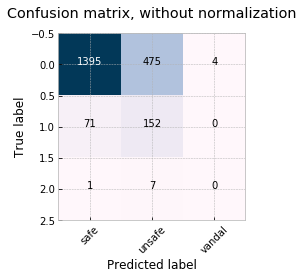

In [9]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

# I need to fix this manually, we should fix this in the future (this look bit clumpsy)
#plt.yticks([2.5,2,1.5,1,0.5,0,-.5], labels=["",label_str[2],"",label_str[1],"",label_str[0]]);

## 8.2 Summary metrics

**TODO**
- look at other scoring metrics for imbalanced data:
    - e.g. Matthews correlation coefficient (MCC)  ==> I think this is one of the best metrics for imbalanced data
    - Cohen's kappa statistic
    - F1 score
    - ...

In [10]:
# F1 score
evaluator_acc = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol='target', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol='target', metricName="f1")

print(f"Acc score: {round(evaluator_acc.evaluate(predictions_live), 4)}")
print(f"F1 score: {round(evaluator_f1.evaluate(predictions_live), 4)}")

Acc score: 0.7349
F1 score: 0.781


In [11]:
# mcc and kappa
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f" MCC: {mcc}")
print(f" Kappa: {kappa}")

 MCC: 0.28641231776283654
 Kappa: 0.2375035135768505


In [12]:
# AUC
results = predictions_live.select(['probability', 'target'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("Area under ROC score is : ", round(metrics.areaUnderROC,4))

Area under ROC score is :  0.7723
